# Classic machine learning approach for sentiment analysis

This notebook presents classic machine learning approach for predicting reviews sentiment. By classic machine learning approach the author means algorithms like Decision Trees, Logistic Regression and so on. The data was analized and prepared for modelling in `data_analysis.ipynb` notebook.

Two cases were tested:
 1. Binary classification where only positive and negative reviews were taken into account
 2. Muliclass classification where all three kinds of reviews were taken into account (positive, neutral and negative)
 
__Reminder__: This is imbalanced classification problem

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, plot_roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [36]:
pd.set_option('display.max_rows', 500)

Loading prepared data

In [37]:
data = pd.read_csv('Data_ML.csv', index_col='Unnamed: 0')

In [38]:
data.head()

,rating,review
0,1,wireless gaming headset gaming headset ticks ...
1,0,good big head low budget easy setup rated 6 ho...
2,1,mezumiwireless gaming headset originally bough...
3,1,hw s2 great headset 2nd mezumi headset kills f...
4,1,best headphones ive purchased entire life prob...


In [39]:
def model_summary(model, X_test, y_test):
    """
    Function that prints classification report and confusion matrix for a given model
    """
    
    y_pred = model.predict(X_test)
    print('\nconfusion matrix\n', confusion_matrix(y_test, y_pred))

    print('\nclassification report\n',classification_report(y_test, y_pred))

In [40]:
#variable for loading the trained models, 
#if it is True the models are loaded from saved pickle files, otherwise the models are fitted (training may take a few days!!!)
load = True

# 1. Binary classification

__In this section only positive and negative reviews are used for building and testing models__<br>

## 1.1 No operations regarding class imbalance

### 1.1.1. Benchmark model - Logistic Regression

In [41]:
#Keeping only positive and negative reviews
data_preprocessed_binary = data[data.rating != 0]

#Words that appear in less than 50 reviews are removed
min_df = 50

In [42]:
X = data_preprocessed_binary.loc[:, 'review']
y = data_preprocessed_binary.loc[:, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

__Three different f1-scoring were tesed in GridSearchCV, it turned out that it does not make any difference__

In [43]:
modelLR = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df)),
    ("model", LogisticRegression(max_iter=10_000, penalty='l2'))
])

paramsLR = { "tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
             "model__C": [0.1, 1, 10],
             "model__class_weight":[{1:1, -1:1}, {1:1, -1:10}, {1:1, -1:20}]}

optimizerLR = GridSearchCV(modelLR, paramsLR, cv=10, scoring='f1_weighted')

#if load is True the model is loaded
if load:
    optimizerLR = pickle.load(open("models/111LogReg_benchamrk.pkl", 'rb'))

#if load is False the model is trained    
else:
    optimizerLR.fit(X_train, y_train)

__Models with two other f1-scoring and ROC curves for all three LogReg models__

In [44]:
# optimizerLR2 = GridSearchCV(modelLR, paramsLR, cv=10, scoring='f1_micro')
# optimizerLR2.fit(X_train, y_train)

# optimizerLR3 = GridSearchCV(modelLR, paramsLR, cv=10, scoring='f1_macro')
# optimizerLR3.fit(X_train, y_train)

# fig, ax = plt.subplots(figsize=(20,10))
# plot_roc_curve(optimizerLR, X_test, y_test, ax=ax)
# plot_roc_curve(optimizerLR2, X_test, y_test, ax=ax)
# plot_roc_curve(optimizerLR3, X_test, y_test, ax=ax)

### 1.1.2. XGBoost

In [45]:
modelXGB= Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", XGBClassifier(n_estimators=500, max_depth=30, objective='binary:logistic'))
])

paramsXGB = {
             "model__reg_lambda":[0.1, 1, 10],
             "model__learning_rate":[0.1, 0.5, 0.9]
            }

optimizerXGB = GridSearchCV(modelXGB, paramsXGB, cv=5, scoring='f1_weighted')

if load:
    optimizerXGB = pickle.load(open("models/112XGB.pkl", 'rb'))
else:
    optimizerXGB.fit(X_train, y_train)

### 1.1.3. SVM

Note: This model had to be limited, the author tried more variables in GridSearch parameters but the model was being fitted for over 7 days without success

In [46]:
modelSVM = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", SVC(probability=True, kernel='rbf'))
])

paramsSVM = {"model__C":[0.1, 1, 10]}

optimizerSVM = GridSearchCV(modelSVM, paramsSVM, cv=5, scoring='f1_weighted')

if load:
    optimizerSVM = pickle.load(open("models/113SVM.pkl", 'rb'))
else:
    optimizerSVM.fit(X_train, y_train)

## 1.2. Undersampling
__The training set is undersampled (number of positive ratings is downgraded in order to obtain balanced labels)__

In [47]:
X = data_preprocessed_binary.loc[:, 'review']
y = data_preprocessed_binary.loc[:, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [48]:
data_train = pd.concat([X_train, y_train], axis=1)

In [49]:
#negative reviews from training set
data_minor = data_train[data_train['rating'] == -1]

#number of negative reviews
minor_size = data_minor.shape[0]

#downsampling the positive ratings
data_major = data_train[data_train['rating'] == 1].sample(n=minor_size)

data_train2 = pd.concat([data_minor, data_major])
X_train = data_train2.loc[:, 'review']
y_train = data_train2.loc[:, 'rating']

In [50]:
print('bad and good reviews after undersampling - percentage and quantity shares\n')
print(data_train2['rating'].value_counts(normalize=True))
print(data_train2['rating'].value_counts(normalize=False))

bad and good reviews after undersampling - percentage and quantity shares

 1    0.5
-1    0.5
Name: rating, dtype: float64
 1    1621
-1    1621
Name: rating, dtype: int64


### 1.2.1. XGBoost

In [51]:
modelXGB_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", XGBClassifier(objective='binary:logistic'))
])

paramsXGB_US = {"model__n_estimators":[100, 300, 500],
                "model__max_depth":[10, 30],
                "model__reg_lambda":[0.1, 1, 10],
                "model__learning_rate":[0.01, 0.1, 0.5, 0.9],
               }

optimizerXGB_US = GridSearchCV(modelXGB_US, paramsXGB_US, cv=5, scoring='f1_macro')

if load:
    optimizerXGB_US = pickle.load(open("models/121XBG.pkl", 'rb'))
else:
    optimizerXGB_US.fit(X_train, y_train)

### 1.2.2. SVM

In [52]:
modelSVM_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df)),
    ("model", SVC())
])

paramsSVM_US = {"tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
             "model__C":[0.1, 1, 10],
             "model__kernel":['rbf','poly','linear'],
             "model__degree":[1,2,3,4,5,6],
            }

optimizerSVM_US = GridSearchCV(modelSVM_US, paramsSVM_US, cv=5, scoring='f1_macro')

if load:
    optimizerSVM_US = pickle.load(open("models/122SVM.pkl", 'rb'))
else:
    optimizerSVM_US.fit(X_train, y_train)

### 1.2.3. KNN

In [53]:
modelKNN_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df)),
    ("model", KNeighborsClassifier())
])

paramsKNN_US = {"tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
             "model__n_neighbors":[3, 5, 10, 15]
            }

optimizerKNN_US = GridSearchCV(modelKNN_US, paramsKNN_US, cv=10, scoring='f1_macro')
if load:
    optimizerKNN_US = pickle.load(open("models/123KNN.pkl", 'rb'))
else:
    optimizerKNN_US.fit(X_train, y_train)

## 1.3. Imblearn library
Library dedicated for imbalanced problems

In [54]:
X = data_preprocessed_binary.loc[:, 'review']
y = data_preprocessed_binary.loc[:, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### 1.3.1. Balanced Random Forest

In [55]:
modelBRF = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", BalancedRandomForestClassifier(replacement=True))
])

paramsBRF = {"model__max_depth": [10, 25],
             "model__n_estimators": [100, 200, 500],
             "model__class_weight": [{1:1, -1:1}, {1:1, -1:10}, {1:1, -1:20}]}

optimizerBRF = GridSearchCV(modelBRF, paramsBRF, cv=5, scoring='f1_weighted')
if load:
    optimizerBRF = pickle.load(open("models/131BRF.pkl", 'rb'))
else:
    optimizerBRF.fit(X_train, y_train)

### 1.3.2. Balanced Boosting

In [56]:
modelBB = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", RUSBoostClassifier(replacement=True))
])


paramsBB = {"model__base_estimator": [LogisticRegression(max_iter=10_000, penalty='none'), 
                                      LogisticRegression(max_iter=10_000, penalty='l2', C=10, class_weight={1:1, -1:10}),
                                      DecisionTreeClassifier(max_depth=15),
                                      KNeighborsClassifier(n_neighbors=5)],
            "model__learning_rate": [0.01, 0.1, 1],
            "model__n_estimators": [100, 200, 500]}


optimizerBB = GridSearchCV(modelBB, paramsBB, cv=10, scoring='f1_weighted')

if load:
    optimizerBB = pickle.load(open("models/132BB.pkl", 'rb'))
else:
    optimizerBB.fit(X_train, y_train)

### ROC for built models for binary case

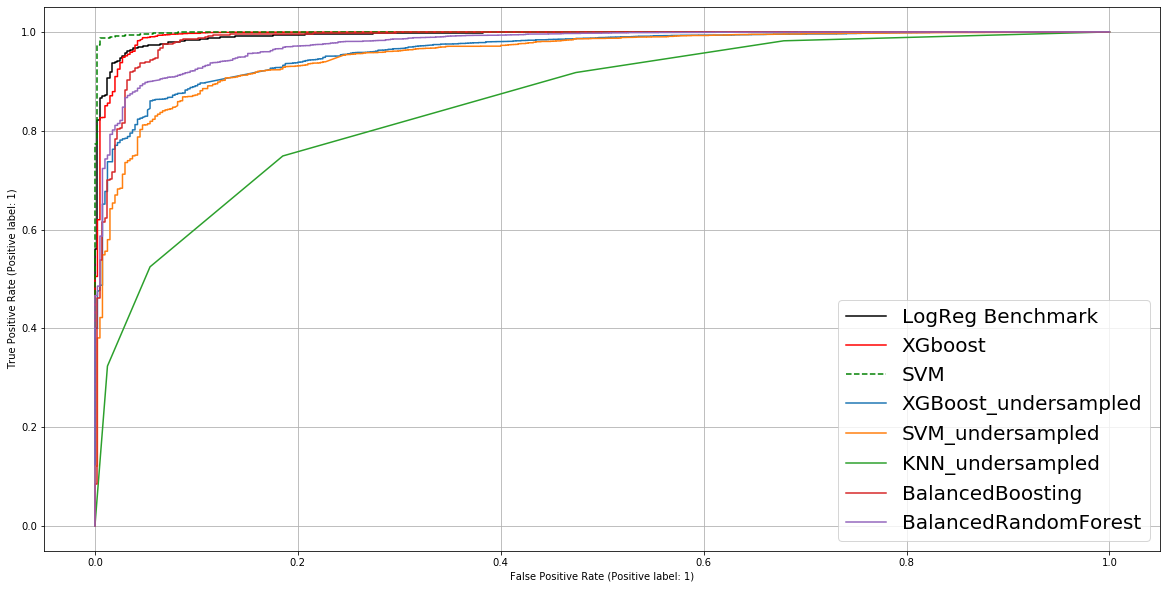

In [57]:
fig, ax = plt.subplots(figsize=(20,10))
plot_roc_curve(optimizerLR, X_test, y_test, ax=ax,color='black')
plot_roc_curve(optimizerXGB, X_test, y_test, ax=ax, color='red')
plot_roc_curve(optimizerSVM, X_test, y_test, ax=ax, color='green', linestyle='--')
plot_roc_curve(optimizerXGB_US, X_test, y_test, ax=ax)
plot_roc_curve(optimizerSVM_US, X_test, y_test, ax=ax)
plot_roc_curve(optimizerKNN_US, X_test, y_test, ax=ax)
plot_roc_curve(optimizerBB, X_test, y_test, ax=ax)
plot_roc_curve(optimizerBRF, X_test, y_test, ax=ax)

ax.legend(['LogReg Benchmark', 'XGboost', 'SVM', 'XGBoost_undersampled', 'SVM_undersampled','KNN_undersampled','BalancedBoosting', 'BalancedRandomForest'], fontsize=20)
ax.grid(b=True)
plt.show()

Conclusion: The best model is SVM without data balancing

In [58]:
final_model_binary = optimizerSVM

__Adjusting probability threshold__ <br>

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, final_model_binary.predict_proba(X_test)[:, 1])

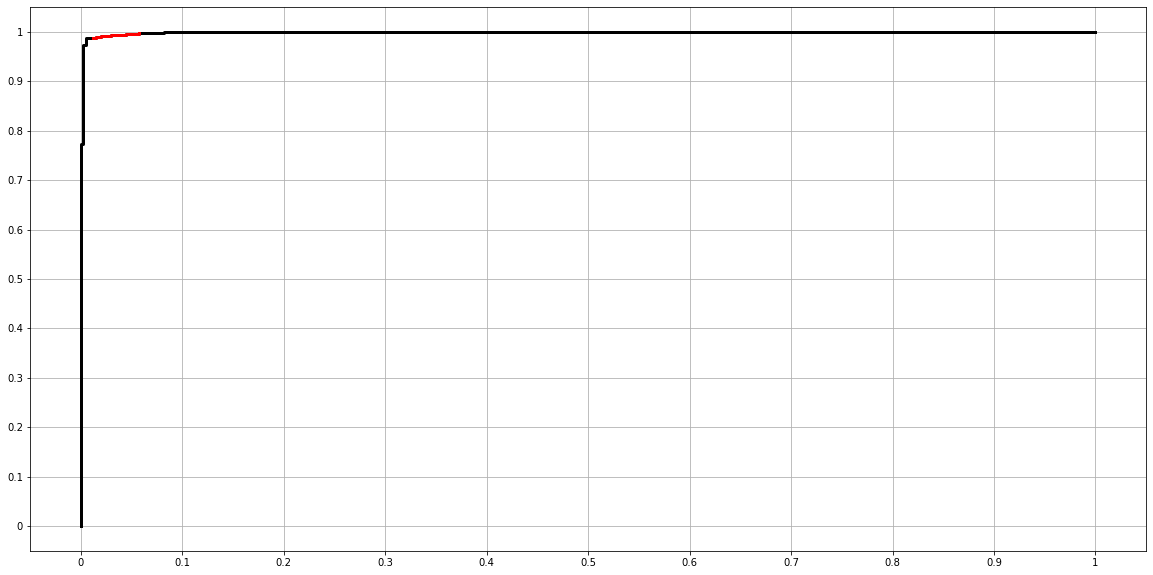

In [60]:
s, e = 160, 190
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(fpr, tpr, color='black', lw=3)
#red curve for determining threshold
ax.plot(fpr[s:e], tpr[s:e], color='red', lw=3)
ax.grid(which='both')
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=np.arange(0,1.1,0.1), labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.show()

In [61]:
##printing values calculated in roc_cuvre in order to select threshold
# np.hstack([tpr.reshape(-1, 1),fpr.reshape(-1, 1), thresholds.reshape(-1, 1)])[s:e]

In [62]:
threshold = 0.8

y_pred_proba_pos = final_model_binary.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_proba_pos > threshold, 1, -1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

print(f'number of reviews that are positive and are predicted as positive: {cm[1][1]}')
print(f'number of reviews that are negative and are predicted as negative: {cm[0][0]}')
print(f'number of reviews that are negative and are predicted as positive: {cm[0][1]}')
print(f'number of reviews that are positive and are predicted as negative: {cm[1][0]}')

[[ 386   19]
 [  36 8421]]
              precision    recall  f1-score   support

          -1       0.91      0.95      0.93       405
           1       1.00      1.00      1.00      8457

    accuracy                           0.99      8862
   macro avg       0.96      0.97      0.97      8862
weighted avg       0.99      0.99      0.99      8862

number of reviews that are positive and are predicted as positive: 8421
number of reviews that are negative and are predicted as negative: 386
number of reviews that are negative and are predicted as positive: 19
number of reviews that are positive and are predicted as negative: 36


__Misclassified reviews__

In [63]:
data_evaluation=pd.DataFrame(np.hstack([y_test.values.reshape(-1,1),y_pred.reshape(-1,1)]), columns=['true','predicted'])
data_evaluation['review'] = X_test.values
idx = data_evaluation['true'] != data_evaluation['predicted']

In [64]:
pd.set_option("max_colwidth", 1000)

In [65]:
#false positive
data_evaluation[idx][data_evaluation.true == -1].head()

,true,predicted,review
20,-1,1,bad game love horse racingespecially triple crown breeders cup game difficult use understandno offense seller not fault
681,-1,1,trailer cable lights cable bit light not quality expectingvfrlam
881,-1,1,cannon powershot a480 not like batteries dead looked like used camera work impression brand new
1163,-1,1,cumbersome difficult use better mounting facilityand usability
1171,-1,1,phone great love phone amazing unit came defect wont read any sim card insert returning phone watch buying product keep mind might return like didedit phone not unlocked begin lowering review 1 starread full review


In [66]:
#false negative
data_evaluation[idx][data_evaluation.true == 1].head()

,true,predicted,review
9,1,-1,always buy norelco ive norelcos 50 years 5 total shavers one gives closer shave 5000 series replaced trimmer built not accessory im 15th day receiving charging fully unfortunately not come travel case issue presentation showed label made netherlands shaver received made china internet research shows ones netherlands better quality would bought anyway no harm no foul minor irritationread full review
97,1,-1,heat 23 hours usage heats ears really irritates
355,1,-1,less hunting use aftermarket adapter focus system better a7 using aftermarket adapter it’s less hunting
449,1,-1,cuts great cant plunge cut worked good tried plunge cut thru 18 steel not cut anymore dont attempt plunge cut blade
558,1,-1,not rushed not hurry since oct 1 2007 not start nowread full review


__Model test__

In [67]:
review = 'this product satisfies me'
print(f'review: {review}')
review = np.array([review])
sentiment = final_model_binary.predict(review)[0]
if sentiment == 1:
    print('the review is positive')
else:
    print('the review is negative')

review: this product satisfies me
the review is positive


# 2. Multilabel classification
__The reviews are divided into three groups: positive, negative and neutral__

In [68]:
def model_summary(model, X_test, y_test):
    """
    Function that prints classification report and confusion matrix for a given model
    """
    
    y_pred = model.predict(X_test)
    print('\nconfusion matrix\n', confusion_matrix(y_test, y_pred))

    print('\nclassification report\n',classification_report(y_test, y_pred))

In [69]:
X = data.loc[:, 'review']
y = data.loc[:, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## 2.1. No operations regarding class imbalance

### 2.1.1. Benchmark model - Logistic Regression 

In [70]:
modelLR_MC = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df)),
    ("model", LogisticRegression(max_iter=10_000, penalty='l2'))
])

paramsLR_MC = { "tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
                "model__C": [0.1, 1, 10],
                "model__class_weight":[{-1:1, 0:1, 1:1}, {-1:10, 0:10, 1:1}]}

optimizerLR_MC = GridSearchCV(modelLR_MC, paramsLR_MC, cv=10, scoring='f1_weighted')

optimizerLR_MC2 = GridSearchCV(modelLR_MC, paramsLR_MC, cv=10, scoring='f1_micro')

optimizerLR_MC3 = GridSearchCV(modelLR_MC, paramsLR_MC, cv=10, scoring='f1_macro')

if load:
    optimizerLR_MC = pickle.load(open("models/211LogReg_benchamrk_MC1.pkl", 'rb'))
    optimizerLR_MC2 = pickle.load(open("models/211LogReg_benchamrk_MC2.pkl", 'rb'))
    optimizerLR_MC3 = pickle.load(open("models/211LogReg_benchamrk_MC3.pkl", 'rb'))
else:
    optimizerLR_MC.fit(X_train, y_train)
    optimizerLR_MC2.fit(X_train, y_train)
    optimizerLR_MC3.fit(X_train, y_train)

### 2.1.2. XGBoost

In [71]:
modelXGB_MC = Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
        ("model", XGBClassifier(objective='multi:softmax', max_depth=30, n_estimators=500, num_class=3, n_jobs=-1))
])

paramsXGB_MC = {
                "model__reg_lambda":[0.1, 1, 10],
                "model__learning_rate":[0.01, 0.1, 0.5, 0.9],
               }

optimizerXGB_MC = GridSearchCV(modelXGB_MC, paramsXGB_MC, cv=5, scoring='f1_weighted')
if load:
    optimizerXGB_MC = pickle.load(open("models/212XGB.pkl", 'rb'))
else:
    optimizerXGB_MC.fit(X_train, y_train)

### 2.1.3. SVM

In [72]:
modelSVM_MC = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", SVC(probability=True, kernel='rbf'))
])

paramsSVM_MC = {"model__C":[0.1, 1, 10]}

optimizerSVM_MC = GridSearchCV(modelSVM_MC, paramsSVM_MC, cv=5, scoring='f1_weighted')

if load:
    optimizerSVM_MC = pickle.load(open("models/213SVM.pkl", 'rb'))
else:
    optimizerSVM_MC.fit(X_train, y_train)

## 2.2. Undersampling

In [73]:
data_train = pd.concat([X_train, y_train], axis=1)

data_minor = data_train[data_train['rating'] == -1]
data_neutral = data_train[data_train['rating'] == 0]

minor_size = data_minor.shape[0]
data_major = data_train[data_train['rating'] == 1].sample(n=minor_size)

data_train2 = pd.concat([data_minor, data_neutral, data_major])
X_train_us = data_train2.loc[:, 'review']
y_train_us = data_train2.loc[:, 'rating']

In [74]:
y_train_us.value_counts()

-1    1621
 1    1621
 0    1153
Name: rating, dtype: int64

### 2.2.1. XGBoost

In [75]:
modelXGB_MC_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", XGBClassifier(objective='multi:softmax', max_depth=30, num_class=3, n_jobs=-1))
])

paramsXGB_MC_US = {
                   "model__n_estimators":[100, 300, 500],
                   "model__reg_lambda":[0.1, 1, 10],
                   "model__learning_rate":[0.01, 0.1, 0.5, 0.9],
                  }

optimizerXGB_MC_US = GridSearchCV(modelXGB_MC_US, paramsXGB_MC_US, cv=10, scoring='f1_macro')
if load:
    optimizerXGB_MC_US = pickle.load(open("models/221XGB.pkl", 'rb'))
else:
    optimizerXGB_MC_US.fit(X_train, y_train)

### 2.2.2. SVM

In [76]:
modelSVM_MC_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=2, max_df=0.1)),
    ("model", SVC())
])

paramsSVM_MC_US = {"tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
                   "model__C":[0.1, 1, 10],
                   "model__kernel":['rbf','poly','linear'],
                   "model__degree":[1,2,3,4,5,6,7],
                  }

optimizerSVM_MC_US = GridSearchCV(modelSVM_MC_US, paramsSVM_MC_US, cv=10, scoring='f1_weighted')
if load:
    optimizerSVM_MC_US = pickle.load(open("models/222SVM.pkl", 'rb'))
else:
    optimizerSVM_MC_US.fit(X_train, y_train)

### 2.2.3. KNN

In [77]:
modelKNN_MC_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=2, max_df=0.1)),
    ("model", KNeighborsClassifier())
])

paramsKNN_MC_US = {"tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
                   "model__n_neighbors":[3, 5, 10, 15]
                  }

optimizerKNN_MC_US = GridSearchCV(modelKNN_MC_US, paramsKNN_MC_US, cv=10, scoring='f1_weighted')
if load:
    optimizerKNN_MC_US = pickle.load(open("models/223KNN.pkl", 'rb'))
else:
    optimizerKNN_MC_US.fit(X_train, y_train)

## 2.3. Imblearn library
__library dedicated for imbalanced problems__

### 2.3.1. Balanced Random Forest

In [78]:
modelBRF_MC = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1, 2))),
    ("model", BalancedRandomForestClassifier(replacement=True))
])

paramsBRF_MC = {"model__max_depth": [10, 25],
                "model__n_estimators": [100, 200, 500],
                "model__class_weight": [{1:1, -1:1, 0:1}, {1:1, -1:10, 0:10}, {1:1, -1:20, 0:20}]}

optimizerBRF_MC = GridSearchCV(modelBRF_MC, paramsBRF_MC, cv=5, scoring='f1_weighted')
if load:
    optimizerBRF_MC = pickle.load(open("models/231BRF.pkl", 'rb'))
else:
    optimizerBRF_MC.fit(X_train, y_train)

### 2.3.2. Balanced Boosting

In [79]:
modelBB_MC = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", RUSBoostClassifier(replacement=True))
])


paramsBB_MC = {"model__base_estimator": [LogisticRegression(max_iter=10_000, penalty='none'), 
                                      LogisticRegression(max_iter=10_000, penalty='l2', C=10, class_weight={1:1, -1:10}),
                                      DecisionTreeClassifier(max_depth=15),
                                      KNeighborsClassifier(n_neighbors=5)],
            "model__learning_rate": [0.01, 0.1, 1],
            "model__n_estimators": [100, 200, 500]}



if load:
    optimizerBB_MC = pickle.load(open("models/232BB.pkl", 'rb'))
else:
    optimizerBB_MC.fit(X_train, y_train)

In [80]:
models = [(optimizerLR_MC, 'LR_MC'),
          (optimizerLR_MC2, 'LR_MC2'),
          (optimizerLR_MC3, 'LR_MC3'),
          (optimizerXGB_MC, 'XGB_MC'),
          (optimizerSVM_MC, 'SVM_MC'),
          (optimizerXGB_MC_US, 'XGB_undersampled'),
          (optimizerSVM_MC_US, 'SVM_undersampled'),
          (optimizerBRF_MC, 'BRF'),
          (optimizerBB_MC, 'BB')]

for m in models:
    print(f'model {m[1]}')
    model_summary(m[0], X_test, y_test)
    print()

model LR_MC

confusion matrix
 [[ 300   11   94]
 [  31   83  175]
 [  34   34 8389]]

classification report
               precision    recall  f1-score   support

          -1       0.82      0.74      0.78       405
           0       0.65      0.29      0.40       289
           1       0.97      0.99      0.98      8457

    accuracy                           0.96      9151
   macro avg       0.81      0.67      0.72      9151
weighted avg       0.95      0.96      0.95      9151


model LR_MC2

confusion matrix
 [[ 232    3  170]
 [  34   24  231]
 [  17   11 8429]]

classification report
               precision    recall  f1-score   support

          -1       0.82      0.57      0.67       405
           0       0.63      0.08      0.15       289
           1       0.95      1.00      0.98      8457

    accuracy                           0.95      9151
   macro avg       0.80      0.55      0.60      9151
weighted avg       0.94      0.95      0.94      9151


model LR_MC3

c

# Summary

Without a doubt SupportVectorClassifier turned out to be the best model in both cases. The algorithm outperformed neural networks as well.  

In [ ]:
# if not load:

#     with open('111LogReg_benchamrk.pkl','wb') as f:
#         pickle.dump(optimizerLR,f)
#     f.close()

#     with open('112XGB.pkl','wb') as f:
#         pickle.dump(optimizerXGB,f)
#     f.close()    

#     with open('113SVM.pkl','wb') as f:
#         pickle.dump(optimizerSVM,f)
#     f.close()    

#     with open('121XBG.pkl','wb') as f:
#         pickle.dump(optimizerXGB_US,f)
#     f.close()    

#     with open('122SVM.pkl','wb') as f:
#         pickle.dump(optimizerSVM_US,f)
#     f.close()    

#     with open('123KNN.pkl','wb') as f:
#         pickle.dump(optimizerKNN_US,f)
#     f.close()    

#     with open('131BRF.pkl','wb') as f:
#         pickle.dump(optimizerBRF,f)
#     f.close()    

#     with open('132BB.pkl','wb') as f:
#         pickle.dump(optimizerBB,f)
#     f.close()
#     with open('211LogReg_benchamrk_MC1.pkl','wb') as f:
#         pickle.dump(optimizerLR_MC,f)
#     f.close()

#     with open('211LogReg_benchamrk_MC2.pkl','wb') as f:
#         pickle.dump(optimizerLR_MC2,f)
#     f.close()

#     with open('211LogReg_benchamrk_MC3.pkl','wb') as f:
#         pickle.dump(optimizerLR_MC3,f)
#     f.close()

#     with open('212XGB.pkl','wb') as f:
#         pickle.dump(optimizerXGB_MC,f)
#     f.close()

#     with open('221XGB.pkl','wb') as f:
#         pickle.dump(optimizerXGB_MC_US,f)
#     f.close()

#     with open('222SVM.pkl','wb') as f:
#         pickle.dump(optimizerSVM_MC_US,f)
#     f.close()

#     with open('223KNN.pkl','wb') as f:
#         pickle.dump(optimizerKNN_MC_US,f)
#     f.close()

#     with open('231BRF.pkl','wb') as f:
#         pickle.dump(optimizerBRF_MC,f)
#     f.close()

#     with open('232BB.pkl','wb') as f:
#         pickle.dump(optimizerBB_MC,f)
#     f.close()